In [6]:
import os

# Download and extract MERGE dataset
DEST_DIR = "/content/drive/MyDrive/Foundation of AI/CS5100 Final Project"
!mkdir -p "{DEST_DIR}"
!wget -O "{DEST_DIR}/MERGE_Bimodal_Complete.zip" \
  https://zenodo.org/records/13939205/files/MERGE_Bimodal_Complete.zip?download=1

# Unzip to a temporary directory first
TEMP_UNZIP_DIR = os.path.join(DEST_DIR, "MERGE_Bimodal_Complete_temp")
!mkdir -p "{TEMP_UNZIP_DIR}"
!unzip -q "{DEST_DIR}/MERGE_Bimodal_Complete.zip" -d "{TEMP_UNZIP_DIR}/"

# Move contents from the extracted folder to DEST_DIR and clean up
# The zip file contains a top-level folder named 'MERGE_Bimodal_Complete'
!mv "{TEMP_UNZIP_DIR}/MERGE_Bimodal_Complete/"* "{DEST_DIR}/"
!rm -rf "{TEMP_UNZIP_DIR}"

!ls "{DEST_DIR}/"

--2025-11-24 03:44:36--  https://zenodo.org/records/13939205/files/MERGE_Bimodal_Complete.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 739234182 (705M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Foundation of AI/CS5100 Final Project/MERGE_Bimodal_Complete.zip’

/content/drive/MyDr 100%[===================>] 704.99M  17.2MB/s    in 92s     

2025-11-24 03:46:09 (7.63 MB/s) - ‘/content/drive/MyDrive/Foundation of AI/CS5100 Final Project/MERGE_Bimodal_Complete.zip’ saved [739234182/739234182]

audio			merge_bimodal_complete_av_values.csv  tvt_dataframes
lyrics			merge_bimodal_complete_metadata.csv
MERGE_Bimodal_Complete	MERGE_Bimodal_Complete.zip


In [1]:
# Install required libraries
!pip install -q tensorflow tensorflow-hub
!pip install -q librosa soundfile

✓ Libraries installed


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from tqdm import tqdm

# Set paths
BASE_DIR = "/content/drive/MyDrive/Foundation of AI/CS5100 Final Project"
AUDIO_DIR = os.path.join(BASE_DIR, "audio")
CSV_PATH = os.path.join(BASE_DIR, "merge_bimodal_complete_av_values.csv")
# Create extracted_features folder inside the project directory
OUTPUT_DIR = os.path.join(BASE_DIR, "extracted_features")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✓ Setup complete")
print(f"Audio folder: {AUDIO_DIR}")
print(f"CSV file: {CSV_PATH}")
print(f"Output folder: {OUTPUT_DIR}")

✓ Setup complete
Audio folder: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/audio
CSV file: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/merge_bimodal_complete_av_values.csv
Output folder: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_features


In [2]:
"""
VGGish Feature Extraction for Music Emotion Recognition

Purpose:
    Extract 128-dimensional audio features from mp3 files using Google's
    pre-trained VGGish model. Features are aggregated using mean pooling
    to produce one feature vector per song.

Input:
    - mp3 audio files organized in Q1/Q2/Q3/Q4 folders
    - CSV file with valence-arousal labels

Output:
    - .npz file containing:
        * features: (num_songs, 128) - VGGish embeddings
        * labels: (num_songs, 2) - [valence, arousal] targets
        * filenames: (num_songs,) - song identifiers

Model: VGGish (frozen pre-trained CNN from TensorFlow Hub)
    - Trained on millions of YouTube videos
    - Processes audio at 16kHz sample rate
    - Outputs 128-dim embeddings per ~0.96s window
"""

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from tqdm import tqdm

# =============================================================================
# CONFIGURATION
# =============================================================================

# Enable test mode to process only 5 songs (recommended for first run)
# Set to False to process all songs
TEST_MODE = False  # Change to False after verifying everything works

# File paths (already defined in Cell 3)
# BASE_DIR, AUDIO_DIR, CSV_PATH, OUTPUT_DIR

# =============================================================================
# STEP 1: LOAD GROUND TRUTH LABELS
# =============================================================================

print("="*70)
print("STEP 1: Loading VA Labels")
print("="*70)

# Load CSV containing Audio_Song, Lyric_Song, Arousal, Valence
df = pd.read_csv(CSV_PATH)

if TEST_MODE:
    print("\n⚠️  TEST MODE: Processing only 5 songs")
    print("Set TEST_MODE = False to process all songs\n")
    df = df.head(5)

print(f"Songs to process: {len(df)}")
print(f"CSV columns: {df.columns.tolist()}\n")
print(df.head(3))

# Check for missing values
missing = df[['Audio_Song', 'Valence', 'Arousal']].isna().sum()
if missing.any():
    print(f"\n⚠️  Missing values detected:\n{missing}")
else:
    print("\n✓ No missing values")

# =============================================================================
# STEP 2: INITIALIZE VGGISH MODEL
# =============================================================================

print("\n" + "="*70)
print("STEP 2: Loading VGGish Model")
print("="*70)

# Load pre-trained VGGish from TensorFlow Hub
# This downloads the model on first run and caches it locally
print("Loading model from TensorFlow Hub...")
vggish_model = hub.load('https://www.kaggle.com/models/google/vggish/TensorFlow2/vggish/1')

print("✓ Model loaded successfully")
print("  Input:  16kHz mono waveform")
print("  Output: 128-dim embeddings per ~0.96s window")

# =============================================================================
# STEP 3: EXTRACT FEATURES
# =============================================================================

print("\n" + "="*70)
print("STEP 3: Feature Extraction")
print("="*70)

# Storage for results
features_list = []     # 128-dim feature vectors
labels_list = []       # [valence, arousal] pairs
filenames_list = []    # Song filenames
errors = []            # Processing errors
quadrant_counts = {'Q1': 0, 'Q2': 0, 'Q3': 0, 'Q4': 0}
num_chunks_list = []   # Temporal chunks per song

# Process each song
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):

    audio_filename = row['Audio_Song']
    valence = row['Valence']
    arousal = row['Arousal']

    # Find audio file in quadrant folders (Q1/Q2/Q3/Q4)
    audio_path = None
    found_quadrant = None

    # Prepare candidate filenames (try adding extension if missing)
    candidates = [audio_filename]
    if not os.path.splitext(audio_filename)[1]:
        candidates.extend([f"{audio_filename}.mp3", f"{audio_filename}.wav"])

    for quadrant in ['Q1', 'Q2', 'Q3', 'Q4']:
        for fname in candidates:
            potential_path = os.path.join(AUDIO_DIR, quadrant, fname)
            if os.path.exists(potential_path):
                audio_path = potential_path
                found_quadrant = quadrant
                break
        if audio_path:
            break

    if audio_path is None:
        errors.append(f"Not found: {audio_filename} (checked {candidates})")
        continue

    try:
        # Load audio at 16kHz (VGGish requirement)
        # Returns: waveform array with shape (num_samples,)
        waveform, sr = librosa.load(audio_path, sr=16000, mono=True)
        assert sr == 16000, f"Sample rate mismatch: {sr}"

        # Extract VGGish embeddings
        # Input:  (num_samples,) waveform
        # Output: (num_windows, 128) temporal features
        embeddings = vggish_model(waveform)
        embeddings = embeddings.numpy()

        # Track temporal chunks
        num_chunks_list.append(embeddings.shape[0])

        # Mean pooling: (num_windows, 128) → (128,)
        # Aggregates temporal features into single vector per song
        features = np.mean(embeddings, axis=0)
        assert features.shape == (128,), f"Shape error: {features.shape}"

        # Store results
        features_list.append(features)
        labels_list.append([valence, arousal])
        filenames_list.append(audio_filename)
        quadrant_counts[found_quadrant] += 1

    except Exception as e:
        errors.append(f"{audio_filename}: {str(e)}")
        continue

# =============================================================================
# STEP 4: PROCESSING SUMMARY
# =============================================================================

print("\n" + "="*70)
print("STEP 4: Summary")
print("="*70)

print(f"Successfully processed: {len(features_list)} songs")
print(f"Errors: {len(errors)}")

print(f"\nQuadrant distribution:")
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    print(f"  {q}: {quadrant_counts[q]:4d} songs")

if errors:
    print(f"\nFirst 5 errors:")
    for err in errors[:5]:
        print(f"  - {err}")

    # Save all errors to file
    error_file = os.path.join(OUTPUT_DIR, 'extraction_errors.txt')
    with open(error_file, 'w') as f:
        f.write('\n'.join(errors))
    print(f"\nAll errors saved to: {error_file}")

# Temporal statistics
if num_chunks_list:
    chunks = np.array(num_chunks_list)
    print(f"\nTemporal chunks per song:")
    print(f"  Mean: {chunks.mean():.1f} chunks")
    print(f"  Range: [{chunks.min()}, {chunks.max()}]")
    print(f"  (1 chunk ≈ 0.96 seconds)")

# =============================================================================
# STEP 5: CONVERT TO NUMPY ARRAYS
# =============================================================================

print("\n" + "="*70)
print("STEP 5: Array Conversion")
print("="*70)

if not features_list:
    print("\n❌ ERROR: No features were extracted from any song.")
    print("Please check the errors above (mostly 'Not found' files).")
    raise RuntimeError("Aborting: No data to save.")

# Convert lists to numpy arrays
X = np.array(features_list, dtype=np.float32)  # Features: (num_songs, 128)
y = np.array(labels_list, dtype=np.float32)    # Labels: (num_songs, 2)
filenames = np.array(filenames_list)            # Filenames: (num_songs,)

print(f"X (features): {X.shape}")
print(f"y (labels):   {y.shape}")
print(f"filenames:    {filenames.shape}")

# Validate shapes
assert X.shape[1] == 128, f"Expected 128 features, got {X.shape[1]}"
assert y.shape[1] == 2, f"Expected 2 labels, got {y.shape[1]}"
assert len(X) == len(y) == len(filenames), "Length mismatch"
print("\n✓ Shape validation passed")

# =============================================================================
# STEP 6: DATA STATISTICS
# =============================================================================

print("\n" + "="*70)
print("STEP 6: Data Statistics")
print("="*70)

# Quality checks
print("Quality checks:")
print(f"  NaN in X: {np.isnan(X).any()}")
print(f"  Inf in X: {np.isinf(X).any()}")
print(f"  NaN in y: {np.isnan(y).any()}")
print(f"  Inf in y: {np.isinf(y).any()}")

if np.isnan(X).any() or np.isinf(X).any():
    print("\n⚠️  WARNING: Data quality issues detected!")

# Feature statistics
print(f"\nFeature statistics:")
print(f"  Mean: {X.mean():.4f}, Std: {X.std():.4f}")
print(f"  Min:  {X.min():.4f}, Max: {X.max():.4f}")

# Per-dimension statistics
dim_means = X.mean(axis=0)
dim_stds = X.std(axis=0)
print(f"\nPer-dimension ranges:")
print(f"  Means: [{dim_means.min():.4f}, {dim_means.max():.4f}]")
print(f"  Stds:  [{dim_stds.min():.4f}, {dim_stds.max():.4f}]")

# Check for zero-variance dimensions
zero_var = np.sum(dim_stds < 1e-6)
if zero_var > 0:
    print(f"\n⚠️  {zero_var} dimensions have near-zero variance")
else:
    print(f"\n✓ All dimensions have meaningful variance")

# Label statistics
print(f"\nValence (target 1):")
print(f"  Mean: {y[:, 0].mean():.4f}, Std: {y[:, 0].std():.4f}")
print(f"  Range: [{y[:, 0].min():.4f}, {y[:, 0].max():.4f}]")

print(f"\nArousal (target 2):")
print(f"  Mean: {y[:, 1].mean():.4f}, Std: {y[:, 1].std():.4f}")
print(f"  Range: [{y[:, 1].min():.4f}, {y[:, 1].max():.4f}]")

# Check V-A correlation (should be low in Russell's model)
corr = np.corrcoef(y[:, 0], y[:, 1])[0, 1]
print(f"\nValence-Arousal correlation: {corr:.4f}")
if abs(corr) < 0.3:
    print("  ✓ Independent dimensions (good)")
else:
    print(f"  ⚠️  Moderate/high correlation")

# Label distribution
v_low = np.sum(y[:, 0] < 0.33)
v_mid = np.sum((y[:, 0] >= 0.33) & (y[:, 0] < 0.67))
v_high = np.sum(y[:, 0] >= 0.67)

a_low = np.sum(y[:, 1] < 0.33)
a_mid = np.sum((y[:, 1] >= 0.33) & (y[:, 1] < 0.67))
a_high = np.sum(y[:, 1] >= 0.67)

print(f"\nLabel distributions:")
print(f"  Valence: Low={v_low}, Mid={v_mid}, High={v_high}")
print(f"  Arousal: Low={a_low}, Mid={a_mid}, High={a_high}")

# =============================================================================
# STEP 7: SAVE FEATURES
# =============================================================================

print("\n" + "="*70)
print("STEP 7: Saving Features")
print("="*70)

output_path = os.path.join(OUTPUT_DIR, 'vggish_features_meanpool.npz')

# Save as compressed numpy archive
np.savez_compressed(
    output_path,
    features=X,        # (num_songs, 128) input features
    labels=y,          # (num_songs, 2) VA targets
    filenames=filenames  # (num_songs,) song IDs
)

# File size information
file_size_mb = os.path.getsize(output_path) / (1024**2)
uncompressed_mb = (X.nbytes + y.nbytes) / (1024**2)

print(f"✓ Saved to: {output_path}")
print(f"✓ File size: {file_size_mb:.2f} MB")
print(f"✓ Compression: {uncompressed_mb/file_size_mb:.1f}x")

# =============================================================================
# STEP 8: EXTRACTION COMPLETE
# =============================================================================

print("\n" + "="*70)
print("EXTRACTION COMPLETE")
print("="*70)

print(f"\nDataset summary:")
print(f"  Songs processed: {len(X)}")
print(f"  Feature dimensions: {X.shape[1]}")
print(f"  Target dimensions: {y.shape[1]}")
if num_chunks_list:
    print(f"  Avg temporal chunks: {np.mean(num_chunks_list):.1f}")

print(f"\nSample (song 0):")
print(f"  File: {filenames[0]}")
print(f"  Features: {X[0][:5]}... (showing first 5 of 128)")
print(f"  Labels: V={y[0, 0]:.4f}, A={y[0, 1]:.4f}")

print(f"\nNext steps:")
print(f"  1. Load data: data = np.load('{output_path}')")
print(f"  2. Split train/val/test (70/15/15)")
print(f"  3. Build linear regression model")
print(f"  4. Train and evaluate")

print("\n" + "="*70)


STEP 1: Loading VA Labels
Songs to process: 2216
CSV columns: ['Audio_Song', 'Lyric_Song', 'Arousal', 'Valence']

  Audio_Song Lyric_Song  Arousal  Valence
0       A001       L051  0.29375  0.89375
1       A002       L052  0.33750  0.68125
2       A003       L053  0.25000  0.22500

✓ No missing values

STEP 2: Loading VGGish Model
Loading model from TensorFlow Hub...
✓ Model loaded successfully
  Input:  16kHz mono waveform
  Output: 128-dim embeddings per ~0.96s window

STEP 3: Feature Extraction


Processing: 100%|██████████| 2216/2216 [33:32<00:00,  1.10it/s]



STEP 4: Summary
Successfully processed: 2216 songs
Errors: 0

Quadrant distribution:
  Q1:  525 songs
  Q2:  673 songs
  Q3:  500 songs
  Q4:  518 songs

Temporal chunks per song:
  Mean: 30.8 chunks
  Range: [4, 32]
  (1 chunk ≈ 0.96 seconds)

STEP 5: Array Conversion
X (features): (2216, 128)
y (labels):   (2216, 2)
filenames:    (2216,)

✓ Shape validation passed

STEP 6: Data Statistics
Quality checks:
  NaN in X: False
  Inf in X: False
  NaN in y: False
  Inf in y: False

Feature statistics:
  Mean: -0.0837, Std: 0.3686
  Min:  -1.9359, Max: 2.1557

Per-dimension ranges:
  Means: [-0.9452, 0.8171]
  Stds:  [0.0325, 0.5036]

✓ All dimensions have meaningful variance

Valence (target 1):
  Mean: 0.5050, Std: 0.2311
  Range: [0.0188, 0.9875]

Arousal (target 2):
  Mean: 0.4823, Std: 0.1395
  Range: [0.0625, 0.9750]

Valence-Arousal correlation: 0.0815
  ✓ Independent dimensions (good)

Label distributions:
  Valence: Low=870, Mid=474, High=872
  Arousal: Low=365, Mid=1732, High=119

In [3]:
"""
Train/Validation/Test Data Splitting

Purpose:
    Split VGGish features into train/val/test sets with stratification
    and feature normalization.

Why stratification?
    Maintains emotion quadrant proportions across splits, ensuring
    validation performance reliably predicts test performance.

Why normalization?
    Standardizes features to mean=0, std=1 for faster, more stable
    gradient descent convergence.

Split: 70% train / 15% validation / 15% test
"""

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

# =============================================================================
# STEP 1: LOAD EXTRACTED FEATURES
# =============================================================================

print("="*70)
print("STEP 1: Loading Extracted Features")
print("="*70)

# Load features extracted in Cell 4
features_path = os.path.join(OUTPUT_DIR, 'vggish_features_meanpool.npz')
data = np.load(features_path)

features = data['features']   # (2216, 128) - VGGish embeddings
labels = data['labels']       # (2216, 2) - [valence, arousal]
song_ids = data['filenames']  # (2216,) - song identifiers

total_songs = len(features)
print(f"Total songs: {total_songs}")
print(f"Features: {features.shape}")
print(f"Labels: {labels.shape}")

# =============================================================================
# STEP 2: ASSIGN QUADRANTS FOR STRATIFICATION
# =============================================================================

print("\n" + "="*70)
print("STEP 2: Assigning Emotion Quadrants")
print("="*70)

# Compute medians to split VA space into quadrants
# Russell's Circumplex Model:
#   Q1: Happy (high V, high A)
#   Q2: Angry (low V, high A)
#   Q3: Sad (low V, low A)
#   Q4: Relaxed (high V, low A)

valence_median = np.median(labels[:, 0])
arousal_median = np.median(labels[:, 1])

print(f"Median thresholds:")
print(f"  Valence: {valence_median:.4f}")
print(f"  Arousal: {arousal_median:.4f}")

# Assign each song to a quadrant
quadrants = np.empty(len(labels), dtype='<U2')

for i in range(len(labels)):
    v, a = labels[i, 0], labels[i, 1]

    if v >= valence_median and a >= arousal_median:
        quadrants[i] = 'Q1'  # Happy
    elif v < valence_median and a >= arousal_median:
        quadrants[i] = 'Q2'  # Angry
    elif v < valence_median and a < arousal_median:
        quadrants[i] = 'Q3'  # Sad
    else:
        quadrants[i] = 'Q4'  # Relaxed

# Show distribution
print(f"\nQuadrant distribution:")
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    count = np.sum(quadrants == q)
    print(f"  {q}: {count:4d} songs ({count/total_songs*100:.1f}%)")

# =============================================================================
# STEP 3: SPLIT 1 - SEPARATE TRAINING SET (70%)
# =============================================================================

print("\n" + "="*70)
print("STEP 3: Creating Training Set (70%)")
print("="*70)

# Split off 70% for training, keep 30% as temporary set
# stratify=quadrants ensures each emotion quadrant is proportionally
# represented in both train and temp sets
X_train, X_temp, y_train, y_temp, ids_train, ids_temp, quad_train, quad_temp = train_test_split(
    features,
    labels,
    song_ids,
    quadrants,
    test_size=0.30,        # 30% to temp (will become val+test)
    random_state=42,       # Seed for reproducibility
    stratify=quadrants,    # Maintain quadrant proportions
    shuffle=True
)

print(f"After Split 1:")
print(f"  Train: {len(X_train):4d} songs ({len(X_train)/total_songs*100:.1f}%)")
print(f"  Temp:  {len(X_temp):4d} songs ({len(X_temp)/total_songs*100:.1f}%)")

# =============================================================================
# STEP 4: SPLIT 2 - SEPARATE VALIDATION (15%) AND TEST (15%)
# =============================================================================

print("\n" + "="*70)
print("STEP 4: Creating Validation and Test Sets (15% each)")
print("="*70)

# Split the temp set (30%) into two equal parts
# 50% of temp = 15% of total for validation
# 50% of temp = 15% of total for test
X_val, X_test, y_val, y_test, ids_val, ids_test, quad_val, quad_test = train_test_split(
    X_temp,
    y_temp,
    ids_temp,
    quad_temp,
    test_size=0.50,        # Split temp equally
    random_state=42,
    stratify=quad_temp     # Maintain quadrant proportions
)

print(f"After Split 2:")
print(f"  Val:  {len(X_val):4d} songs ({len(X_val)/total_songs*100:.1f}%)")
print(f"  Test: {len(X_test):4d} songs ({len(X_test)/total_songs*100:.1f}%)")

# =============================================================================
# STEP 5: VERIFY SPLIT RATIOS AND NO OVERLAP
# =============================================================================

print("\n" + "="*70)
print("STEP 5: Verification")
print("="*70)

# Check final split percentages
print(f"FINAL SPLIT:")
print(f"  Train: {len(X_train):4d} songs ({len(X_train)/total_songs*100:.1f}%)")
print(f"  Val:   {len(X_val):4d} songs ({len(X_val)/total_songs*100:.1f}%)")
print(f"  Test:  {len(X_test):4d} songs ({len(X_test)/total_songs*100:.1f}%)")
print(f"  Total: {len(X_train)+len(X_val)+len(X_test):4d} songs")

# Verify no songs appear in multiple splits (critical!)
assert len(set(ids_train) & set(ids_val)) == 0, "ERROR: Train-Val overlap!"
assert len(set(ids_train) & set(ids_test)) == 0, "ERROR: Train-Test overlap!"
assert len(set(ids_val) & set(ids_test)) == 0, "ERROR: Val-Test overlap!"
print(f"\n✓ No overlap between splits verified!")

# Verify stratification maintained quadrant proportions
print(f"\nStratification verification:")
print(f"{'Split':<12} {'Q1':>6} {'Q2':>6} {'Q3':>6} {'Q4':>6}")
print("-" * 42)

for split_name, quad_split in [('Original', quadrants),
                                ('Train', quad_train),
                                ('Val', quad_val),
                                ('Test', quad_test)]:
    counts = [np.sum(quad_split == q) for q in ['Q1', 'Q2', 'Q3', 'Q4']]
    pcts = [f"{c/len(quad_split)*100:.1f}%" for c in counts]
    print(f"{split_name:<12} {counts[0]:4d}({pcts[0]:>5}) {counts[1]:4d}({pcts[1]:>5}) {counts[2]:4d}({pcts[2]:>5}) {counts[3]:4d}({pcts[3]:>5})")

print("\n✓ Stratification successful")

# =============================================================================
# STEP 6: NORMALIZE FEATURES
# =============================================================================

print("\n" + "="*70)
print("STEP 6: Feature Normalization (Standardization)")
print("="*70)

# Normalize features to mean=0, std=1
#
# Why? Your VGGish features have inconsistent scales:
#   - Some dimensions: std=0.03 (small variance)
#   - Other dimensions: std=0.50 (large variance - 16x bigger!)
#
# During gradient descent, the gradient = residual × features
# Without normalization:
#   - High-variance features dominate gradient updates
#   - Low-variance features barely update (even if important!)
#   - Training is slow and unstable
#
# With normalization (StandardScaler):
#   - All 128 dimensions have std=1.0
#   - All features contribute equally to gradients
#   - Faster convergence, more stable training
#
# Formula: z = (x - mean) / std  (applied per feature dimension)

scaler = StandardScaler()

# CRITICAL: Fit scaler ONLY on training data
# Why? To prevent "data leakage" from validation/test sets
# Validation and test should simulate "unseen future data"
# Using their statistics would be cheating!
scaler.fit(X_train)

print("Before normalization:")
print(f"  Train - Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")

# Apply the SAME transformation to all three splits
# This ensures consistent scaling across train/val/test
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"\nAfter normalization:")
print(f"  Train - Mean: {X_train.mean():.6f}, Std: {X_train.std():.6f}")
print(f"  Val   - Mean: {X_val.mean():.6f}, Std: {X_val.std():.6f}")
print(f"  Test  - Mean: {X_test.mean():.6f}, Std: {X_test.std():.6f}")

print(f"\n✓ Features normalized")
print(f"  Method: StandardScaler (z-score normalization)")
print(f"  Fitted on: Training set only")
print(f"  Applied to: Train, Val, Test")

# =============================================================================
# STEP 7: SAVE SPLITS
# =============================================================================

print("\n" + "="*70)
print("STEP 7: Saving Splits")
print("="*70)

# Create splits directory
splits_dir = os.path.join(OUTPUT_DIR, 'splits')
os.makedirs(splits_dir, exist_ok=True)

# Save training set
np.save(os.path.join(splits_dir, 'X_train.npy'), X_train)
np.save(os.path.join(splits_dir, 'y_train.npy'), y_train)
np.save(os.path.join(splits_dir, 'ids_train.npy'), ids_train)

# Save validation set
np.save(os.path.join(splits_dir, 'X_val.npy'), X_val)
np.save(os.path.join(splits_dir, 'y_val.npy'), y_val)
np.save(os.path.join(splits_dir, 'ids_val.npy'), ids_val)

# Save test set (DON'T TOUCH until final evaluation!)
np.save(os.path.join(splits_dir, 'X_test.npy'), X_test)
np.save(os.path.join(splits_dir, 'y_test.npy'), y_test)
np.save(os.path.join(splits_dir, 'ids_test.npy'), ids_test)

# Save scaler parameters for later use
# We'll need these to normalize new data during inference
np.save(os.path.join(splits_dir, 'scaler_mean.npy'), scaler.mean_)
np.save(os.path.join(splits_dir, 'scaler_std.npy'), scaler.scale_)

print(f"✓ All splits saved to: {splits_dir}")

# Show saved files
print(f"\nSaved files:")
for filename in sorted(os.listdir(splits_dir)):
    filepath = os.path.join(splits_dir, filename)
    size_kb = os.path.getsize(filepath) / 1024
    print(f"  {filename:<20} {size_kb:>8.1f} KB")

# =============================================================================
# STEP 8: FINAL SUMMARY
# =============================================================================

print("\n" + "="*70)
print("DATA SPLITTING COMPLETE")
print("="*70)

print(f"\nDataset splits:")
print(f"  Training:   {len(X_train):4d} songs - for learning model weights")
print(f"  Validation: {len(X_val):4d} songs - for tuning hyperparameters")
print(f"  Test:       {len(X_test):4d} songs - for final evaluation only!")

print(f"\nPreprocessing applied:")
print(f"  ✓ Stratified sampling by emotion quadrant")
print(f"  ✓ Feature normalization (StandardScaler)")

print(f"\nLabel statistics:")
for name, y_split in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    v_mean = y_split[:, 0].mean()
    a_mean = y_split[:, 1].mean()
    print(f"  {name:<10} Valence: {v_mean:.3f}  Arousal: {a_mean:.3f}")

print("\n🚀 Ready for model building!")
print("="*70)

STEP 1: Loading Extracted Features
Total songs: 2216
Features: (2216, 128)
Labels: (2216, 2)

STEP 2: Assigning Emotion Quadrants
Median thresholds:
  Valence: 0.3988
  Arousal: 0.5063

Quadrant distribution:
  Q1:  544 songs (24.5%)
  Q2:  651 songs (29.4%)
  Q3:  452 songs (20.4%)
  Q4:  569 songs (25.7%)

STEP 3: Creating Training Set (70%)
After Split 1:
  Train: 1551 songs (70.0%)
  Temp:   665 songs (30.0%)

STEP 4: Creating Validation and Test Sets (15% each)
After Split 2:
  Val:   332 songs (15.0%)
  Test:  333 songs (15.0%)

STEP 5: Verification
FINAL SPLIT:
  Train: 1551 songs (70.0%)
  Val:    332 songs (15.0%)
  Test:   333 songs (15.0%)
  Total: 2216 songs

✓ No overlap between splits verified!

Stratification verification:
Split            Q1     Q2     Q3     Q4
------------------------------------------
Original      544(24.5%)  651(29.4%)  452(20.4%)  569(25.7%)
Train         381(24.6%)  456(29.4%)  316(20.4%)  398(25.7%)
Val            82(24.7%)   97(29.2%)   68(20.5

OPTION A: LINEAR REGRESSION MODEL
Configuration:
  Batch size: 32
  Max epochs: 100
  Initial learning rate: 0.01
  Step size strategy: Decreasing (η = 1/√updates)

STEP 1: Loading Data Splits
Training set:   1551 songs
Validation set: 332 songs
Test set:       333 songs

✓ Data loaded and converted to tensors
  Batches per epoch: 49

STEP 2: Building Linear Model
Model architecture:
  Input:  128 dimensions (VGGish features)
  Output: 2 dimensions (valence, arousal)
  Layers: 1 linear layer

Parameters:
  Weight matrix W: torch.Size([2, 128]) = 256 params
  Bias vector b:   torch.Size([2]) = 2 params
  Total parameters: 258

✓ Model created

STEP 3: Defining Loss Function
Loss function: Mean Squared Error (MSE)
  Formula: (1/n) Σ(predicted - actual)²
  Applied to both valence and arousal

STEP 4: Training Setup
Optimizer: Stochastic Gradient Descent (SGD)
  Initial learning rate: 0.01
  Learning rate schedule: η = 0.01/√(num_updates)

✓ Training setup complete

STEP 5: Training Linear

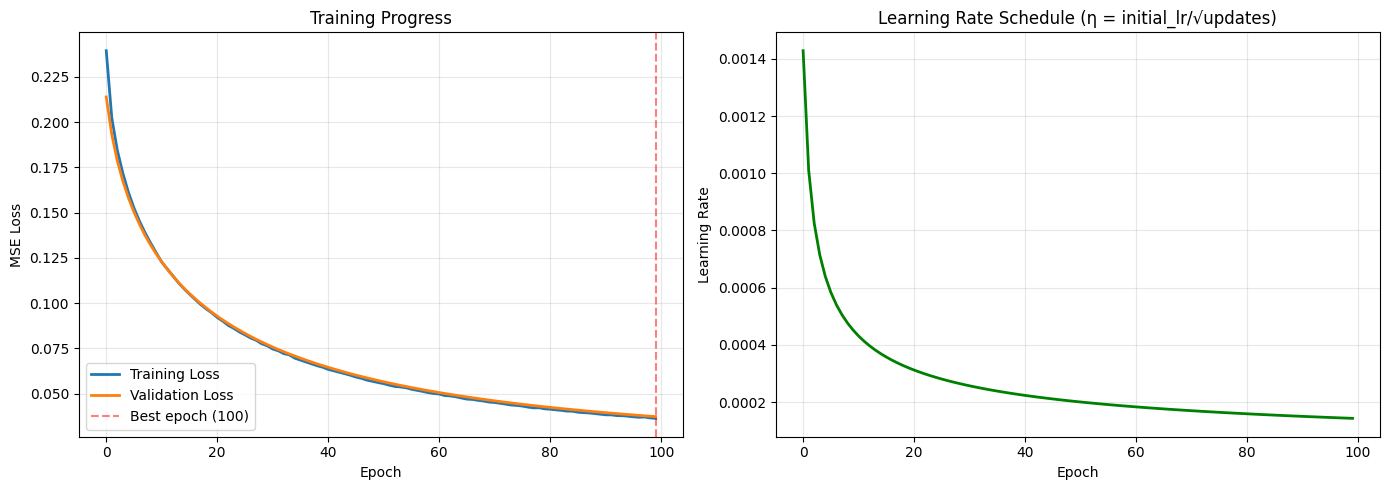

✓ Training curves saved to: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_features/results/linear_model_training.png

STEP 8: Visualizing Predictions


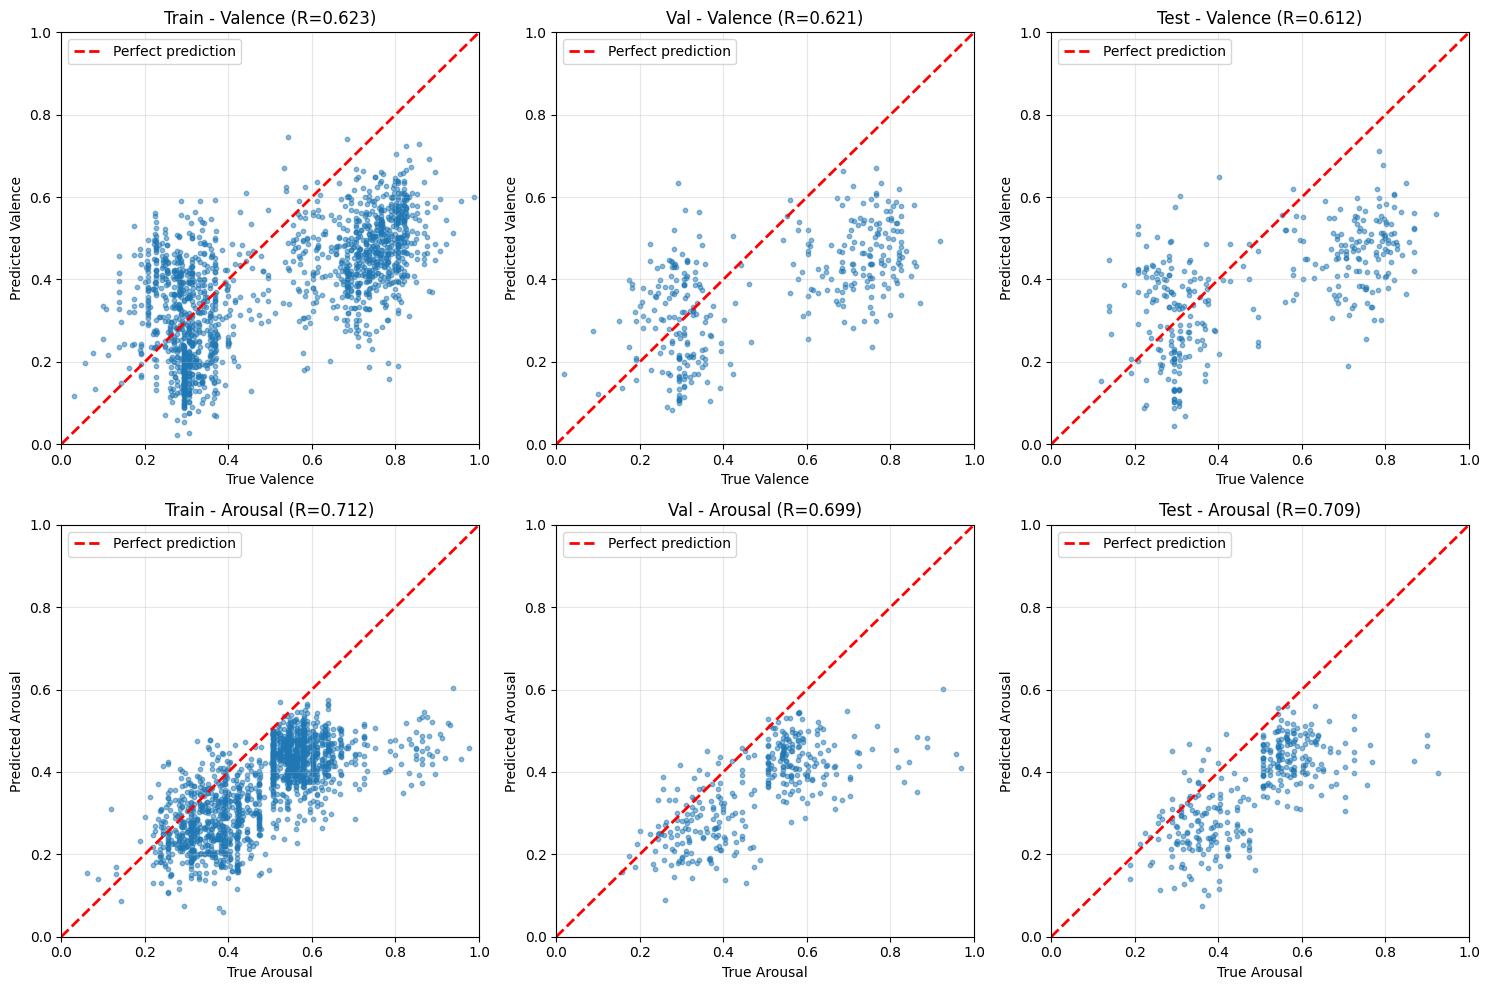

✓ Prediction plots saved to: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_features/results/linear_model_predictions.png

STEP 9: Analyzing Learned Weights
Weight matrix W: (2, 128)
  Valence weights (W[0]): 128 features
  Arousal weights (W[1]): 128 features

Bias vector b: (2,)
  Valence bias: 0.380837
  Arousal bias: 0.363285

Weight statistics:
  Valence weights - Mean: 0.000227, Std: 0.008864
  Arousal weights - Mean: -0.000040, Std: 0.008492

Top 5 most important features:

  Valence:
    Feature  52: weight=-0.024510
    Feature 106: weight=-0.021768
    Feature  50: weight=+0.020891
    Feature 102: weight=+0.020332
    Feature  65: weight=-0.017924

  Arousal:
    Feature  90: weight=+0.027860
    Feature  92: weight=+0.024029
    Feature  79: weight=+0.019414
    Feature 103: weight=+0.019102
    Feature  94: weight=-0.017743

STEP 10: Saving Model and Results
✓ Model saved to: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_fea

In [4]:
"""
Option A: Linear Regression Model for VA Prediction

Model Architecture:
    f_w(x) = W · φ(x)
    - Input: 128-dim VGGish features (φ(x))
    - Output: 2-dim VA coordinates [valence, arousal]
    - Weights: W is a (2, 128) matrix

Loss Function:
    MSE (Mean Squared Error) = (1/n) Σ(predicted - actual)²

Optimization:
    Mini-batch SGD with decreasing step size
    Step size: η = 1/√(num_updates)

From lecture: "Start simple" - this is our baseline to establish
performance floor before moving to neural networks.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

# =============================================================================
# CONFIGURATION
# =============================================================================

# Hyperparameters
BATCH_SIZE = 32          # Mini-batch size (lecture: "small subset e.g. 32")
NUM_EPOCHS = 100         # Maximum number of training epochs
INITIAL_LR = 0.01        # Initial learning rate
RANDOM_SEED = 42         # For reproducibility

# Paths
SPLITS_DIR = os.path.join(OUTPUT_DIR, 'splits')
RESULTS_DIR = os.path.join(OUTPUT_DIR, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("="*70)
print("OPTION A: LINEAR REGRESSION MODEL")
print("="*70)
print(f"Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Initial learning rate: {INITIAL_LR}")
print(f"  Step size strategy: Decreasing (η = 1/√updates)")

# =============================================================================
# STEP 1: LOAD TRAIN/VAL/TEST SPLITS
# =============================================================================

print("\n" + "="*70)
print("STEP 1: Loading Data Splits")
print("="*70)

# Load the splits we created in Cell 5
X_train = np.load(os.path.join(SPLITS_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(SPLITS_DIR, 'y_train.npy'))

X_val = np.load(os.path.join(SPLITS_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(SPLITS_DIR, 'y_val.npy'))

X_test = np.load(os.path.join(SPLITS_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(SPLITS_DIR, 'y_test.npy'))

print(f"Training set:   {X_train.shape[0]} songs")
print(f"Validation set: {X_val.shape[0]} songs")
print(f"Test set:       {X_test.shape[0]} songs")

# Convert numpy arrays to PyTorch tensors
# PyTorch requires tensor format for automatic gradient computation
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoaders for mini-batch processing
# DataLoader automatically:
#   - Shuffles data each epoch
#   - Creates batches of size BATCH_SIZE
#   - Handles the last incomplete batch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ Data loaded and converted to tensors")
print(f"  Batches per epoch: {len(train_loader)}")

# =============================================================================
# STEP 2: DEFINE LINEAR MODEL
# =============================================================================

print("\n" + "="*70)
print("STEP 2: Building Linear Model")
print("="*70)

# Define the linear regression model
# Architecture: f_w(x) = W · x + b
#   - Input: 128 features
#   - Output: 2 values (valence, arousal)
#   - Parameters: W (2×128 matrix) + b (2-dim bias vector)
#   - Total parameters: 2×128 + 2 = 258 parameters
#
# From lecture notation:
#   f_w(x) = w · φ(x)
#   where φ(x) = [1, x] includes bias implicitly
#   Our model does this automatically with bias=True

class LinearRegressionModel(nn.Module):
    """
    Simple linear regression model for VA prediction.

    Architecture:
        Input (128) → Linear → Output (2)

    Parameters:
        - Weight matrix W: (2, 128)
        - Bias vector b: (2,)
        - Total: 258 trainable parameters
    """

    def __init__(self, input_dim=128, output_dim=2):
        super(LinearRegressionModel, self).__init__()

        # Single linear layer: y = W·x + b
        self.linear = nn.Linear(input_dim, output_dim)

        # Initialize weights
        # From lecture: "Careful initialization"
        # We use small random values from normal distribution
        nn.init.normal_(self.linear.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x: Input features, shape (batch_size, 128)

        Returns:
            predictions: VA predictions, shape (batch_size, 2)
        """
        return self.linear(x)

# Instantiate the model
model = LinearRegressionModel(input_dim=128, output_dim=2)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model architecture:")
print(f"  Input:  128 dimensions (VGGish features)")
print(f"  Output: 2 dimensions (valence, arousal)")
print(f"  Layers: 1 linear layer")
print(f"\nParameters:")
print(f"  Weight matrix W: {model.linear.weight.shape} = {model.linear.weight.numel()} params")
print(f"  Bias vector b:   {model.linear.bias.shape} = {model.linear.bias.numel()} params")
print(f"  Total parameters: {total_params}")

print(f"\n✓ Model created")

# =============================================================================
# STEP 3: DEFINE LOSS FUNCTION
# =============================================================================

print("\n" + "="*70)
print("STEP 3: Defining Loss Function")
print("="*70)

# Mean Squared Error (MSE) loss
# From lecture: Loss(x, y, w) = (f_w(x) - y)²
#
# For our case with 2 outputs:
#   MSE = (1/n) Σ[(predicted_valence - true_valence)² +
#                  (predicted_arousal - true_arousal)²]
#
# PyTorch's MSELoss computes this automatically
criterion = nn.MSELoss()

print(f"Loss function: Mean Squared Error (MSE)")
print(f"  Formula: (1/n) Σ(predicted - actual)²")
print(f"  Applied to both valence and arousal")

# =============================================================================
# STEP 4: TRAINING SETUP
# =============================================================================

print("\n" + "="*70)
print("STEP 4: Training Setup")
print("="*70)

# We'll implement decreasing step size manually
# From lecture: "Decreasing: η = 1/√(# updates made so far)"
#
# PyTorch optimizers expect a fixed learning rate, so we'll update it manually

# Start with SGD optimizer (we'll adjust learning rate each step)
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR)

print(f"Optimizer: Stochastic Gradient Descent (SGD)")
print(f"  Initial learning rate: {INITIAL_LR}")
print(f"  Learning rate schedule: η = {INITIAL_LR}/√(num_updates)")

# Initialize tracking variables
# Lecture: "Log everything"
train_losses = []      # Track training loss per epoch
val_losses = []        # Track validation loss per epoch
learning_rates = []    # Track learning rate over time
num_updates = 0        # Total number of weight updates made

print(f"\n✓ Training setup complete")

# =============================================================================
# STEP 5: TRAINING LOOP
# =============================================================================

print("\n" + "="*70)
print("STEP 5: Training Linear Model")
print("="*70)

# From lecture: "Algorithm: gradient descent"
#   Initialize w = [0, ..., 0]
#   For t = 1, ..., T:
#       For (x, y) ∈ D_train:
#           w ← w - η∇_w Loss(x, y, w)

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Progress will be shown every 10 epochs\n")

best_val_loss = float('inf')  # Track best validation performance
best_epoch = 0

for epoch in range(NUM_EPOCHS):

    # -------------------------------------------------------------------------
    # TRAINING PHASE
    # -------------------------------------------------------------------------
    model.train()  # Set model to training mode

    epoch_train_loss = 0.0
    num_batches = 0

    # Process mini-batches
    # From lecture: "Mini-batch gradient descent: balance of speed & stability"
    for batch_X, batch_y in train_loader:

        # Forward pass: compute predictions
        # predictions = W · X + b
        predictions = model(batch_X)

        # Compute loss for this batch
        # loss = MSE(predictions, targets)
        loss = criterion(predictions, batch_y)

        # Backward pass: compute gradients
        # This uses backpropagation (Lecture 3)
        # Automatically computes ∇_w Loss using chain rule
        optimizer.zero_grad()  # Clear old gradients
        loss.backward()        # Compute new gradients

        # Update weights with current learning rate
        # w ← w - η∇_w Loss
        optimizer.step()

        # Update learning rate with decreasing schedule
        # η = initial_lr / √(num_updates)
        num_updates += 1
        new_lr = INITIAL_LR / np.sqrt(num_updates)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

        # Accumulate loss for this epoch
        epoch_train_loss += loss.item()
        num_batches += 1

    # Average training loss for this epoch
    avg_train_loss = epoch_train_loss / num_batches
    train_losses.append(avg_train_loss)
    learning_rates.append(new_lr)

    # -------------------------------------------------------------------------
    # VALIDATION PHASE
    # -------------------------------------------------------------------------
    # Evaluate on validation set without updating weights
    # This tells us how well the model generalizes
    model.eval()  # Set model to evaluation mode (turns off dropout, etc.)

    epoch_val_loss = 0.0
    num_val_batches = 0

    # torch.no_grad() disables gradient computation (faster, uses less memory)
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            epoch_val_loss += loss.item()
            num_val_batches += 1

    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)

    # Track best model based on validation performance
    # Lecture: "Use validation set to choose hyperparameters"
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the best model weights
        best_model_state = model.state_dict().copy()

    # -------------------------------------------------------------------------
    # PROGRESS LOGGING
    # -------------------------------------------------------------------------
    # Print progress every 10 epochs
    # Lecture: "Log everything"
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"LR: {new_lr:.6f}")

print(f"\n✓ Training complete!")
print(f"  Best validation loss: {best_val_loss:.6f} (epoch {best_epoch+1})")

# Load best model weights
model.load_state_dict(best_model_state)

# =============================================================================
# STEP 6: EVALUATE MODEL PERFORMANCE
# =============================================================================

print("\n" + "="*70)
print("STEP 6: Model Evaluation")
print("="*70)

def evaluate_model(model, X, y, split_name):
    """
    Evaluate model performance using MSE and Pearson correlation.

    Metrics:
        - MSE: Mean Squared Error (lower is better)
        - R_valence: Pearson correlation for valence predictions
        - R_arousal: Pearson correlation for arousal predictions
        - R_mean: Average of R_valence and R_arousal

    Args:
        model: Trained PyTorch model
        X: Feature tensor
        y: Label tensor (ground truth)
        split_name: Name of split ("Train", "Val", "Test")

    Returns:
        dict with metrics
    """
    model.eval()

    with torch.no_grad():
        # Get predictions for entire split
        predictions = model(X).numpy()
        ground_truth = y.numpy()

    # Compute MSE
    mse = np.mean((predictions - ground_truth) ** 2)

    # Compute Pearson correlation for each dimension
    # Correlation measures linear relationship between predicted and actual
    # Range: [-1, 1] where 1 = perfect prediction, 0 = no relationship
    r_valence, _ = pearsonr(predictions[:, 0], ground_truth[:, 0])
    r_arousal, _ = pearsonr(predictions[:, 1], ground_truth[:, 1])
    r_mean = (r_valence + r_arousal) / 2

    # Print results
    print(f"\n{split_name} Set Performance:")
    print(f"  MSE:        {mse:.6f}")
    print(f"  R_valence:  {r_valence:.6f}")
    print(f"  R_arousal:  {r_arousal:.6f}")
    print(f"  R_mean:     {r_mean:.6f}")

    return {
        'mse': mse,
        'r_valence': r_valence,
        'r_arousal': r_arousal,
        'r_mean': r_mean,
        'predictions': predictions,
        'ground_truth': ground_truth
    }

# Evaluate on all three splits
train_results = evaluate_model(model, X_train_tensor, y_train_tensor, "Training")
val_results = evaluate_model(model, X_val_tensor, y_val_tensor, "Validation")

# NOTE: We evaluate on test ONLY to see baseline performance
# In practice, you wouldn't look at test until after hyperparameter tuning
test_results = evaluate_model(model, X_test_tensor, y_test_tensor, "Test")

# =============================================================================
# STEP 7: VISUALIZE TRAINING PROGRESS
# =============================================================================

print("\n" + "="*70)
print("STEP 7: Visualizing Training Progress")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training and validation loss over epochs
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best epoch ({best_epoch+1})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Learning rate decay over epochs
axes[1].plot(learning_rates, linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule (η = initial_lr/√updates)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(RESULTS_DIR, 'linear_model_training.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to: {plot_path}")

# =============================================================================
# STEP 8: VISUALIZE PREDICTIONS VS GROUND TRUTH
# =============================================================================

print("\n" + "="*70)
print("STEP 8: Visualizing Predictions")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# For each split (train, val, test) and each dimension (valence, arousal)
for col, (split_name, results) in enumerate([('Train', train_results),
                                               ('Val', val_results),
                                               ('Test', test_results)]):
    pred = results['predictions']
    true = results['ground_truth']

    # Valence predictions (row 0)
    axes[0, col].scatter(true[:, 0], pred[:, 0], alpha=0.5, s=10)
    axes[0, col].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
    axes[0, col].set_xlabel('True Valence')
    axes[0, col].set_ylabel('Predicted Valence')
    axes[0, col].set_title(f'{split_name} - Valence (R={results["r_valence"]:.3f})')
    axes[0, col].legend()
    axes[0, col].grid(True, alpha=0.3)
    axes[0, col].set_xlim([0, 1])
    axes[0, col].set_ylim([0, 1])

    # Arousal predictions (row 1)
    axes[1, col].scatter(true[:, 1], pred[:, 1], alpha=0.5, s=10)
    axes[1, col].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
    axes[1, col].set_xlabel('True Arousal')
    axes[1, col].set_ylabel('Predicted Arousal')
    axes[1, col].set_title(f'{split_name} - Arousal (R={results["r_arousal"]:.3f})')
    axes[1, col].legend()
    axes[1, col].grid(True, alpha=0.3)
    axes[1, col].set_xlim([0, 1])
    axes[1, col].set_ylim([0, 1])

plt.tight_layout()
pred_plot_path = os.path.join(RESULTS_DIR, 'linear_model_predictions.png')
plt.savefig(pred_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Prediction plots saved to: {pred_plot_path}")

# =============================================================================
# STEP 9: ANALYZE MODEL WEIGHTS
# =============================================================================

print("\n" + "="*70)
print("STEP 9: Analyzing Learned Weights")
print("="*70)

# Extract learned weights
# W shape: (2, 128) - one row for valence, one row for arousal
W = model.linear.weight.detach().numpy()
b = model.linear.bias.detach().numpy()

print(f"Weight matrix W: {W.shape}")
print(f"  Valence weights (W[0]): {W.shape[1]} features")
print(f"  Arousal weights (W[1]): {W.shape[1]} features")

print(f"\nBias vector b: {b.shape}")
print(f"  Valence bias: {b[0]:.6f}")
print(f"  Arousal bias: {b[1]:.6f}")

# Analyze weight magnitudes
# Larger absolute weights = more important features
print(f"\nWeight statistics:")
print(f"  Valence weights - Mean: {W[0].mean():.6f}, Std: {W[0].std():.6f}")
print(f"  Arousal weights - Mean: {W[1].mean():.6f}, Std: {W[1].std():.6f}")

# Find most important features for each dimension
# "Important" = largest absolute weight value
top_k = 5
print(f"\nTop {top_k} most important features:")

# For valence
valence_importance = np.abs(W[0])
top_valence_indices = np.argsort(valence_importance)[-top_k:][::-1]
print(f"\n  Valence:")
for idx in top_valence_indices:
    print(f"    Feature {idx:3d}: weight={W[0, idx]:+.6f}")

# For arousal
arousal_importance = np.abs(W[1])
top_arousal_indices = np.argsort(arousal_importance)[-top_k:][::-1]
print(f"\n  Arousal:")
for idx in top_arousal_indices:
    print(f"    Feature {idx:3d}: weight={W[1, idx]:+.6f}")

# =============================================================================
# STEP 10: SAVE MODEL AND RESULTS
# =============================================================================

print("\n" + "="*70)
print("STEP 10: Saving Model and Results")
print("="*70)

# Save trained model weights
model_path = os.path.join(RESULTS_DIR, 'linear_model.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
}, model_path)

print(f"✓ Model saved to: {model_path}")

# Save training history
history_path = os.path.join(RESULTS_DIR, 'linear_model_history.npz')
np.savez(
    history_path,
    train_losses=np.array(train_losses),
    val_losses=np.array(val_losses),
    learning_rates=np.array(learning_rates)
)

print(f"✓ Training history saved to: {history_path}")

# Save predictions for analysis
predictions_path = os.path.join(RESULTS_DIR, 'linear_model_predictions.npz')
np.savez(
    predictions_path,
    train_pred=train_results['predictions'],
    train_true=train_results['ground_truth'],
    val_pred=val_results['predictions'],
    val_true=val_results['ground_truth'],
    test_pred=test_results['predictions'],
    test_true=test_results['ground_truth']
)

print(f"✓ Predictions saved to: {predictions_path}")

# Save metrics summary
metrics_path = os.path.join(RESULTS_DIR, 'linear_model_metrics.txt')
with open(metrics_path, 'w') as f:
    f.write("LINEAR REGRESSION MODEL - PERFORMANCE METRICS\n")
    f.write("="*70 + "\n\n")

    f.write("Model Configuration:\n")
    f.write(f"  Architecture: Linear (128 → 2)\n")
    f.write(f"  Parameters: {total_params}\n")
    f.write(f"  Batch size: {BATCH_SIZE}\n")
    f.write(f"  Epochs trained: {NUM_EPOCHS}\n")
    f.write(f"  Best epoch: {best_epoch+1}\n")
    f.write(f"  Learning rate: Decreasing (η = {INITIAL_LR}/√updates)\n\n")

    f.write("Performance Metrics:\n")
    f.write("-"*70 + "\n")
    f.write(f"{'Split':<12} {'MSE':<12} {'R_valence':<12} {'R_arousal':<12} {'R_mean':<12}\n")
    f.write("-"*70 + "\n")

    for name, res in [('Train', train_results), ('Val', val_results), ('Test', test_results)]:
        f.write(f"{name:<12} {res['mse']:<12.6f} {res['r_valence']:<12.6f} {res['r_arousal']:<12.6f} {res['r_mean']:<12.6f}\n")

print(f"✓ Metrics summary saved to: {metrics_path}")

# =============================================================================
# STEP 11: FINAL SUMMARY
# =============================================================================

print("\n" + "="*70)
print("OPTION A: LINEAR REGRESSION - COMPLETE")
print("="*70)

print(f"\nModel Performance Summary:")
print(f"{'Split':<12} {'MSE':<12} {'R_valence':<12} {'R_arousal':<12} {'R_mean':<12}")
print("-"*70)
for name, res in [('Train', train_results), ('Val', val_results), ('Test', test_results)]:
    print(f"{name:<12} {res['mse']:<12.6f} {res['r_valence']:<12.6f} {res['r_arousal']:<12.6f} {res['r_mean']:<12.6f}")

print(f"\nKey observations:")
print(f"  • Training converged in {best_epoch+1} epochs")
print(f"  • Best validation MSE: {best_val_loss:.6f}")

# Check for overfitting
# If train loss << val loss, model is overfitting
train_val_gap = train_results['mse'] - val_results['mse']
if abs(train_val_gap) < 0.01:
    print(f"  ✓ Good generalization (train-val gap: {train_val_gap:.6f})")
elif train_val_gap < -0.02:
    print(f"  ⚠️  Possible overfitting (train much better than val)")
else:
    print(f"  ✓ Reasonable train-val gap: {train_val_gap:.6f}")

print(f"\nSaved artifacts:")
print(f"  • Model weights: {model_path}")
print(f"  • Training history: {history_path}")
print(f"  • Predictions: {predictions_path}")
print(f"  • Metrics summary: {metrics_path}")

print("\n🚀 Next: Option B - Two-Layer Neural Network")
print("  Expected improvement with non-linear model!")
print("="*70)

NEURAL NETWORK BASELINE MODEL
Device: cuda

Architecture: 128 → 64 → 32 → 2
Dropout: 0.3
Optimizer: Adam (lr=0.001, weight_decay=0.0001)
Early stopping patience: 15 epochs

STEP 1: Loading Data
Train: 1551 samples, shape: (1551, 128)
Val:   332 samples, shape: (332, 128)
Test:  333 samples, shape: (333, 128)

STEP 2: Creating Datasets and DataLoaders
✓ DataLoaders created
  Training batches per epoch: 49
  Validation batches: 11
  Test batches: 11

STEP 3: Initializing Neural Network
Model architecture:
AudioNeuralNetwork(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=32, out_features=2, bias=True)
)

Total trainable parameters: 10,402

Parameter breakdown:
  FC1: 64 × 128 + 64 = 8,256
  FC2: 32 × 64 + 32 = 2,080
  Out: 2 × 32 + 2 = 66
  Total: 10,402

Comparison:
  Linear model: 258 parameters


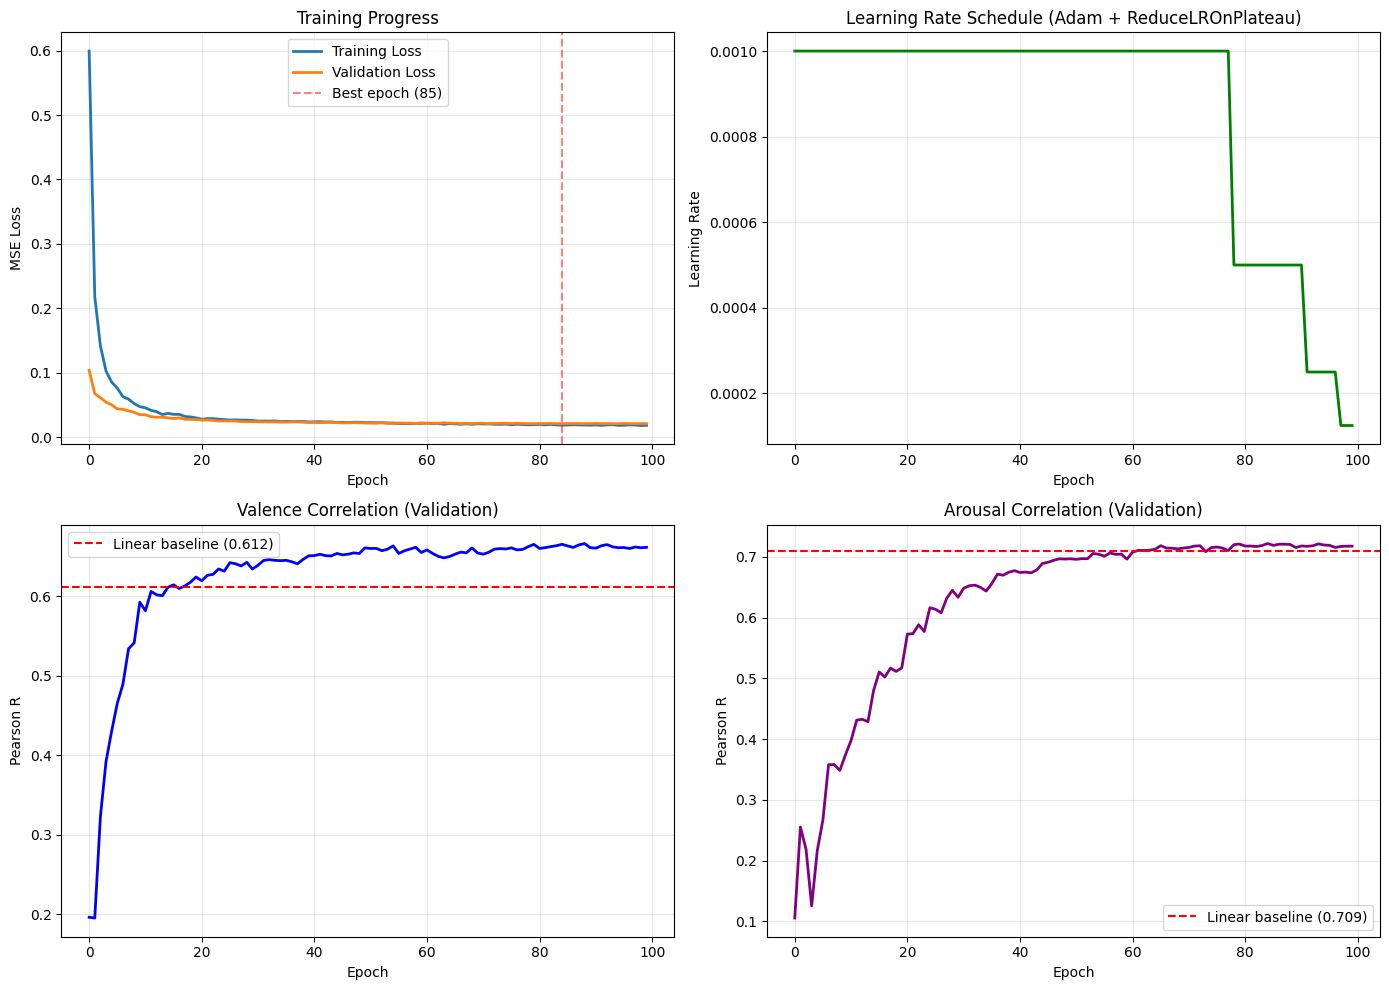

✓ Training analysis saved to: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_features/results/nn_training_analysis.png

STEP 9: Saving Results
✓ Predictions saved to: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_features/results/nn_predictions.npz
✓ History saved to: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_features/results/nn_training_history.npz
✓ Metrics saved to: /content/drive/MyDrive/Foundation of AI/CS5100 Final Project/extracted_features/results/nn_metrics.txt

NEURAL NETWORK TRAINING COMPLETE

Best Neural Network Performance (Test Set):
  MSE:        0.018697
  R_valence:  0.686215
  R_arousal:  0.751116
  R_mean:     0.718665

Comparison with Linear Baseline:
  MSE:        +48.43% improvement
  R_mean:     +8.82% improvement

📊 Model Selection for Multimodal Fusion:
  ✅ RECOMMEND: Neural Network
     Significant improvement over linear baseline
     R_mean: 0.719 vs 0.660


In [9]:
"""
Neural Network Baseline for VA Prediction

Architecture: 3-layer network with dropout
    Input (128) → FC1 (64) → ReLU → Dropout
                → FC2 (32) → ReLU → Dropout
                → Output (2: valence, arousal)

This architecture previously achieved:
    R_valence = 0.705, R_arousal = 0.761 on DEAM dataset

Improvements over simple 2-layer:
    - Deeper architecture (3 layers vs 2)
    - Dropout for regularization
    - Adam optimizer (adaptive learning rates)
    - Learning rate scheduling
    - Early stopping
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

# =============================================================================
# CONFIGURATION
# =============================================================================

# Model hyperparameters
INPUT_DIM = 128          # VGGish feature dimensions
HIDDEN_DIM1 = 64         # First hidden layer size
HIDDEN_DIM2 = 32         # Second hidden layer size
OUTPUT_DIM = 2           # Valence and arousal
DROPOUT_RATE = 0.3       # Dropout probability (prevents overfitting)

# Training hyperparameters
BATCH_SIZE = 32          # Mini-batch size
NUM_EPOCHS = 100         # Maximum training epochs
LEARNING_RATE = 0.001    # Initial learning rate for Adam
WEIGHT_DECAY = 1e-4      # L2 regularization strength

# Early stopping
PATIENCE = 15            # Stop if no improvement for 15 epochs

# Paths
SPLITS_DIR = os.path.join(OUTPUT_DIR, 'splits')
RESULTS_DIR = os.path.join(OUTPUT_DIR, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print("="*70)
print("NEURAL NETWORK BASELINE MODEL")
print("="*70)
print(f"Device: {device}")
print(f"\nArchitecture: {INPUT_DIM} → {HIDDEN_DIM1} → {HIDDEN_DIM2} → {OUTPUT_DIM}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Early stopping patience: {PATIENCE} epochs")

# =============================================================================
# DATASET CLASS
# =============================================================================

class AudioDataset(Dataset):
    """
    PyTorch Dataset for VGGish features and VA labels.

    Wraps numpy arrays into PyTorch dataset format for DataLoader.
    DataLoader handles batching, shuffling, and parallel loading.
    """

    def __init__(self, features, labels):
        """
        Args:
            features: numpy array of shape (num_songs, 128)
            labels: numpy array of shape (num_songs, 2)
        """
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        """Return total number of samples"""
        return len(self.features)

    def __getitem__(self, idx):
        """
        Get one sample.

        Args:
            idx: Index of sample to retrieve

        Returns:
            tuple: (features, labels) for song at index idx
        """
        return self.features[idx], self.labels[idx]

# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================

class AudioNeuralNetwork(nn.Module):
    """
    Three-layer neural network for valence-arousal prediction.

    Architecture:
        Input (128) → FC1 (64) → ReLU → Dropout (0.3)
                    → FC2 (32) → ReLU → Dropout (0.3)
                    → Output (2)

    From lecture: "Neural networks yield non-linear predictors"
    The ReLU activations introduce non-linearity, allowing the model
    to learn complex patterns that linear models cannot capture.

    Dropout: Randomly sets neurons to 0 during training
    - Prevents overfitting (co-adaptation of neurons)
    - From lecture: "Dropout" is a regularization technique
    - Only active during training, turned off during evaluation
    """

    def __init__(self, input_dim=128, hidden_dim1=64, hidden_dim2=32,
                 output_dim=2, dropout=0.3):
        super(AudioNeuralNetwork, self).__init__()

        # Layer 1: Input → First hidden layer
        # Maps 128 VGGish features to 64 hidden neurons
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)

        # Layer 2: First hidden → Second hidden layer
        # Maps 64 neurons to 32 neurons (progressive dimensionality reduction)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)

        # Layer 3: Second hidden → Output
        # Maps 32 neurons to 2 outputs (valence, arousal)
        self.fc_out = nn.Linear(hidden_dim2, output_dim)

        # Initialize weights with Xavier initialization
        # Good initialization helps training converge faster
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Xavier uniform initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        Forward pass through the network.

        Computation graph (from lecture):
            x → fc1 → relu → dropout → fc2 → relu → dropout → fc_out → output

        Args:
            x: Input features, shape (batch_size, 128)

        Returns:
            output: Predictions, shape (batch_size, 2) [valence, arousal]
        """
        # Layer 1: Linear + ReLU + Dropout
        x = self.fc1(x)          # (batch_size, 64)
        x = torch.relu(x)        # Apply ReLU: max(0, x)
        x = self.dropout1(x)     # Randomly drop 30% of neurons

        # Layer 2: Linear + ReLU + Dropout
        x = self.fc2(x)          # (batch_size, 32)
        x = torch.relu(x)
        x = self.dropout2(x)

        # Output layer: Linear (no activation for regression)
        x = self.fc_out(x)       # (batch_size, 2)

        return x

# =============================================================================
# TRAINING FUNCTION
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train model for one epoch.

    One epoch = one complete pass through the training data

    Process:
        1. Set model to training mode (enables dropout)
        2. For each mini-batch:
            - Forward pass: compute predictions
            - Compute loss: MSE(predictions, targets)
            - Backward pass: compute gradients via backpropagation
            - Update weights: w ← w - η∇Loss
        3. Return average loss for this epoch

    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        criterion: Loss function (MSE)
        optimizer: Optimization algorithm (Adam)
        device: CPU or GPU

    Returns:
        float: Average training loss for this epoch
    """
    model.train()  # Enable dropout and batch normalization

    total_loss = 0.0
    num_batches = 0

    for features, labels in train_loader:
        # Move data to device (GPU if available)
        features = features.to(device)
        labels = labels.to(device)

        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass: compute predictions
        predictions = model(features)

        # Compute loss: MSE between predictions and true labels
        loss = criterion(predictions, labels)

        # Backward pass: compute gradients using backpropagation
        # From lecture: "Backpropagation computes gradients automatically"
        loss.backward()

        # Update weights: w ← w - η∇Loss
        # Adam automatically adjusts learning rate per parameter
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()
        num_batches += 1

    # Return average loss across all batches
    return total_loss / num_batches

# =============================================================================
# EVALUATION FUNCTION
# =============================================================================

def evaluate(model, data_loader, criterion, device):
    """
    Evaluate model on validation or test set.

    Computes:
        - MSE loss
        - Pearson correlation for valence predictions
        - Pearson correlation for arousal predictions

    Args:
        model: Neural network model
        data_loader: DataLoader for val/test data
        criterion: Loss function (MSE)
        device: CPU or GPU

    Returns:
        tuple: (avg_loss, r_valence, r_arousal)
    """
    model.eval()  # Disable dropout (use all neurons for inference)

    total_loss = 0.0
    all_predictions = []
    all_labels = []

    # torch.no_grad() disables gradient computation
    # Saves memory and speeds up evaluation
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass only (no backward pass during evaluation)
            predictions = model(features)

            # Compute loss
            loss = criterion(predictions, labels)
            total_loss += loss.item()

            # Store predictions and labels for correlation calculation
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all batches
    all_predictions = np.vstack(all_predictions)  # (num_songs, 2)
    all_labels = np.vstack(all_labels)            # (num_songs, 2)

    # Compute Pearson correlation
    # Measures linear relationship between predicted and actual values
    # Range: [-1, 1] where 1 = perfect positive correlation
    r_valence, _ = pearsonr(all_predictions[:, 0], all_labels[:, 0])
    r_arousal, _ = pearsonr(all_predictions[:, 1], all_labels[:, 1])

    avg_loss = total_loss / len(data_loader)

    return avg_loss, r_valence, r_arousal

# =============================================================================
# STEP 1: LOAD DATA
# =============================================================================

print("\n" + "="*70)
print("STEP 1: Loading Data")
print("="*70)

# Load splits from Cell 5
X_train = np.load(os.path.join(SPLITS_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(SPLITS_DIR, 'y_train.npy'))

X_val = np.load(os.path.join(SPLITS_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(SPLITS_DIR, 'y_val.npy'))

X_test = np.load(os.path.join(SPLITS_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(SPLITS_DIR, 'y_test.npy'))

print(f"Train: {len(X_train)} samples, shape: {X_train.shape}")
print(f"Val:   {len(X_val)} samples, shape: {X_val.shape}")
print(f"Test:  {len(X_test)} samples, shape: {X_test.shape}")

# =============================================================================
# STEP 2: CREATE DATASETS AND DATALOADERS
# =============================================================================

print("\n" + "="*70)
print("STEP 2: Creating Datasets and DataLoaders")
print("="*70)

# Wrap data in Dataset objects
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create DataLoaders for mini-batch processing
# DataLoader handles:
#   - Batching (groups samples into batches)
#   - Shuffling (randomizes order each epoch for training)
#   - Parallel loading (if num_workers > 0)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle training data each epoch
    num_workers=0          # 0 for Colab, 2-4 for local machines
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # Don't shuffle validation (not necessary)
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"✓ DataLoaders created")
print(f"  Training batches per epoch: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# =============================================================================
# STEP 3: INITIALIZE MODEL
# =============================================================================

print("\n" + "="*70)
print("STEP 3: Initializing Neural Network")
print("="*70)

# Create model instance
model = AudioNeuralNetwork(
    input_dim=INPUT_DIM,
    hidden_dim1=HIDDEN_DIM1,
    hidden_dim2=HIDDEN_DIM2,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT_RATE
).to(device)

# Display architecture
print(f"Model architecture:")
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")

# Break down by layer
print(f"\nParameter breakdown:")
print(f"  FC1: {HIDDEN_DIM1} × {INPUT_DIM} + {HIDDEN_DIM1} = {HIDDEN_DIM1 * INPUT_DIM + HIDDEN_DIM1:,}")
print(f"  FC2: {HIDDEN_DIM2} × {HIDDEN_DIM1} + {HIDDEN_DIM2} = {HIDDEN_DIM2 * HIDDEN_DIM1 + HIDDEN_DIM2:,}")
print(f"  Out: {OUTPUT_DIM} × {HIDDEN_DIM2} + {OUTPUT_DIM} = {OUTPUT_DIM * HIDDEN_DIM2 + OUTPUT_DIM:,}")
print(f"  Total: {total_params:,}")

print(f"\nComparison:")
print(f"  Linear model: 258 parameters")
print(f"  This model: {total_params:,} parameters ({total_params/258:.1f}x larger)")

# =============================================================================
# STEP 4: LOSS FUNCTION AND OPTIMIZER
# =============================================================================

print("\n" + "="*70)
print("STEP 4: Setting Up Loss and Optimizer")
print("="*70)

# Loss function: Mean Squared Error
# Same as linear model for fair comparison
criterion = nn.MSELoss()

# Optimizer: Adam (Adaptive Moment Estimation)
# Adam is usually better than vanilla SGD because:
#   - Adaptive learning rates per parameter
#   - Momentum helps escape local minima
#   - Less sensitive to learning rate choice
#
# weight_decay: L2 regularization penalty
# From lecture: "L2 regularization shrinks weights toward zero"
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
# Reduces learning rate when validation loss plateaus
# mode='min': reduce LR when metric stops decreasing
# factor=0.5: multiply LR by 0.5 when triggered
# patience=5: wait 5 epochs before reducing
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
)

print(f"Loss function: MSE")
print(f"Optimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay (L2): {WEIGHT_DECAY}")
print(f"\nLR Scheduler: ReduceLROnPlateau")
print(f"  Reduces LR by 50% if no improvement for 5 epochs")

# =============================================================================
# STEP 5: TRAINING LOOP
# =============================================================================

print("\n" + "="*70)
print("STEP 5: Training Neural Network")
print("="*70)

# Tracking variables
train_losses = []
val_losses = []
val_r_valences = []
val_r_arousals = []
learning_rates = []

best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

print(f"Starting training for up to {NUM_EPOCHS} epochs")
print(f"Early stopping if no improvement for {PATIENCE} epochs\n")

for epoch in range(NUM_EPOCHS):

    # Train for one epoch
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate on validation set
    val_loss, r_valence, r_arousal = evaluate(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_r_valences.append(r_valence)
    val_r_arousals.append(r_arousal)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Print progress
    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
          f"Train: {train_loss:.4f} | "
          f"Val: {val_loss:.4f} | "
          f"R_val: {r_valence:.3f} | "
          f"R_ar: {r_arousal:.3f} | "
          f"LR: {current_lr:.6f}")

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Save best model based on validation performance
    # From lecture: "Use validation set to choose best model"
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict().copy()
        patience_counter = 0

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, os.path.join(RESULTS_DIR, 'best_nn_model.pth'))

        print(f"  → Best model saved (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1

    # Early stopping check
    # From lecture: "Try to minimize error, but don't try too hard"
    # Stopping early prevents overfitting
    if patience_counter >= PATIENCE:
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        print(f"   No improvement for {PATIENCE} consecutive epochs")
        break

print(f"\n✓ Training complete!")
print(f"  Total epochs: {epoch+1}")
print(f"  Best epoch: {best_epoch+1}")
print(f"  Best val loss: {best_val_loss:.6f}")

# Load best model weights
model.load_state_dict(best_model_state)

# =============================================================================
# STEP 6: FINAL EVALUATION ON ALL SPLITS
# =============================================================================

print("\n" + "="*70)
print("STEP 6: Final Evaluation")
print("="*70)

# Evaluate best model on all three splits
print("Evaluating best model...")

train_loss, train_r_val, train_r_ar = evaluate(model, train_loader, criterion, device)
val_loss, val_r_val, val_r_ar = evaluate(model, val_loader, criterion, device)
test_loss, test_r_val, test_r_ar = evaluate(model, test_loader, criterion, device)

# Compute R_mean
train_r_mean = (train_r_val + train_r_ar) / 2
val_r_mean = (val_r_val + val_r_ar) / 2
test_r_mean = (test_r_val + test_r_ar) / 2

print(f"\nFinal Results:")
print(f"{'Split':<12} {'MSE':<12} {'R_valence':<12} {'R_arousal':<12} {'R_mean':<12}")
print("-"*70)
print(f"{'Train':<12} {train_loss:<12.6f} {train_r_val:<12.6f} {train_r_ar:<12.6f} {train_r_mean:<12.6f}")
print(f"{'Validation':<12} {val_loss:<12.6f} {val_r_val:<12.6f} {val_r_ar:<12.6f} {val_r_mean:<12.6f}")
print(f"{'Test':<12} {test_loss:<12.6f} {test_r_val:<12.6f} {test_r_ar:<12.6f} {test_r_mean:<12.6f}")

# =============================================================================
# STEP 7: COMPARE WITH LINEAR BASELINE
# =============================================================================

print("\n" + "="*70)
print("STEP 7: Comparison with Linear Baseline")
print("="*70)

# Linear model test results from Cell 6
linear_test_mse = 0.036255
linear_test_r_val = 0.611655
linear_test_r_ar = 0.709148
linear_test_r_mean = 0.660401

print(f"Test Set Comparison:")
print(f"{'Metric':<15} {'Linear':<12} {'Neural Net':<12} {'Improvement':<12}")
print("-"*70)

# MSE (lower is better)
mse_improvement = ((linear_test_mse - test_loss) / linear_test_mse) * 100
print(f"{'MSE':<15} {linear_test_mse:<12.6f} {test_loss:<12.6f} {mse_improvement:>+11.2f}%")

# R_valence (higher is better)
r_val_improvement = ((test_r_val - linear_test_r_val) / linear_test_r_val) * 100
print(f"{'R_valence':<15} {linear_test_r_val:<12.6f} {test_r_val:<12.6f} {r_val_improvement:>+11.2f}%")

# R_arousal (higher is better)
r_ar_improvement = ((test_r_ar - linear_test_r_ar) / linear_test_r_ar) * 100
print(f"{'R_arousal':<15} {linear_test_r_ar:<12.6f} {test_r_ar:<12.6f} {r_ar_improvement:>+11.2f}%")

# R_mean (higher is better)
r_mean_improvement = ((test_r_mean - linear_test_r_mean) / linear_test_r_mean) * 100
print(f"{'R_mean':<15} {linear_test_r_mean:<12.6f} {test_r_mean:<12.6f} {r_mean_improvement:>+11.2f}%")

# =============================================================================
# STEP 8: VISUALIZE TRAINING PROGRESS
# =============================================================================

print("\n" + "="*70)
print("STEP 8: Visualizing Training")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training and validation loss
axes[0, 0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0, 0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0, 0].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5,
                   label=f'Best epoch ({best_epoch+1})')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Progress')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Learning rate over epochs
axes[0, 1].plot(learning_rates, linewidth=2, color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Schedule (Adam + ReduceLROnPlateau)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Valence correlation over epochs
axes[1, 0].plot(val_r_valences, linewidth=2, color='blue')
axes[1, 0].axhline(y=linear_test_r_val, color='r', linestyle='--',
                   label=f'Linear baseline ({linear_test_r_val:.3f})')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Pearson R')
axes[1, 0].set_title('Valence Correlation (Validation)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Arousal correlation over epochs
axes[1, 1].plot(val_r_arousals, linewidth=2, color='purple')
axes[1, 1].axhline(y=linear_test_r_ar, color='r', linestyle='--',
                   label=f'Linear baseline ({linear_test_r_ar:.3f})')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Pearson R')
axes[1, 1].set_title('Arousal Correlation (Validation)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(RESULTS_DIR, 'nn_training_analysis.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training analysis saved to: {plot_path}")

# =============================================================================
# STEP 9: SAVE RESULTS
# =============================================================================

print("\n" + "="*70)
print("STEP 9: Saving Results")
print("="*70)

# Save final predictions
predictions_path = os.path.join(RESULTS_DIR, 'nn_predictions.npz')

# Get predictions on all splits
model.eval()
with torch.no_grad():
    train_pred = model(torch.FloatTensor(X_train).to(device)).cpu().numpy()
    val_pred = model(torch.FloatTensor(X_val).to(device)).cpu().numpy()
    test_pred = model(torch.FloatTensor(X_test).to(device)).cpu().numpy()

np.savez_compressed(
    predictions_path,
    train_pred=train_pred,
    train_true=y_train,
    val_pred=val_pred,
    val_true=y_val,
    test_pred=test_pred,
    test_true=y_test
)

# Save training history
history_path = os.path.join(RESULTS_DIR, 'nn_training_history.npz')
np.savez(
    history_path,
    train_losses=np.array(train_losses),
    val_losses=np.array(val_losses),
    val_r_valences=np.array(val_r_valences),
    val_r_arousals=np.array(val_r_arousals),
    learning_rates=np.array(learning_rates)
)

# Save metrics summary
metrics_path = os.path.join(RESULTS_DIR, 'nn_metrics.txt')
with open(metrics_path, 'w') as f:
    f.write("NEURAL NETWORK MODEL - PERFORMANCE METRICS\n")
    f.write("="*70 + "\n\n")

    f.write("Architecture:\n")
    f.write(f"  Layers: {INPUT_DIM} → {HIDDEN_DIM1} → {HIDDEN_DIM2} → {OUTPUT_DIM}\n")
    f.write(f"  Activation: ReLU\n")
    f.write(f"  Dropout: {DROPOUT_RATE}\n")
    f.write(f"  Parameters: {total_params:,}\n\n")

    f.write("Training Configuration:\n")
    f.write(f"  Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})\n")
    f.write(f"  Batch size: {BATCH_SIZE}\n")
    f.write(f"  Epochs trained: {epoch+1}\n")
    f.write(f"  Best epoch: {best_epoch+1}\n\n")

    f.write("Performance:\n")
    f.write("-"*70 + "\n")
    f.write(f"{'Split':<12} {'MSE':<12} {'R_valence':<12} {'R_arousal':<12} {'R_mean':<12}\n")
    f.write("-"*70 + "\n")
    f.write(f"{'Train':<12} {train_loss:<12.6f} {train_r_val:<12.6f} {train_r_ar:<12.6f} {train_r_mean:<12.6f}\n")
    f.write(f"{'Validation':<12} {val_loss:<12.6f} {val_r_val:<12.6f} {val_r_ar:<12.6f} {val_r_mean:<12.6f}\n")
    f.write(f"{'Test':<12} {test_loss:<12.6f} {test_r_val:<12.6f} {test_r_ar:<12.6f} {test_r_mean:<12.6f}\n\n")

    f.write("Comparison with Linear Baseline:\n")
    f.write("-"*70 + "\n")
    f.write(f"  MSE improvement: {mse_improvement:+.2f}%\n")
    f.write(f"  R_valence improvement: {r_val_improvement:+.2f}%\n")
    f.write(f"  R_arousal improvement: {r_ar_improvement:+.2f}%\n")
    f.write(f"  R_mean improvement: {r_mean_improvement:+.2f}%\n")

print(f"✓ Predictions saved to: {predictions_path}")
print(f"✓ History saved to: {history_path}")
print(f"✓ Metrics saved to: {metrics_path}")

# =============================================================================
# STEP 10: FINAL SUMMARY AND RECOMMENDATION
# =============================================================================

print("\n" + "="*70)
print("NEURAL NETWORK TRAINING COMPLETE")
print("="*70)

print(f"\nBest Neural Network Performance (Test Set):")
print(f"  MSE:        {test_loss:.6f}")
print(f"  R_valence:  {test_r_val:.6f}")
print(f"  R_arousal:  {test_r_ar:.6f}")
print(f"  R_mean:     {test_r_mean:.6f}")

print(f"\nComparison with Linear Baseline:")
print(f"  MSE:        {mse_improvement:+.2f}% improvement")
print(f"  R_mean:     {r_mean_improvement:+.2f}% improvement")

# Model selection recommendation
print(f"\n📊 Model Selection for Multimodal Fusion:")

if test_r_mean > linear_test_r_mean + 0.02:
    print(f"  ✅ RECOMMEND: Neural Network")
    print(f"     Significant improvement over linear baseline")
    print(f"     R_mean: {test_r_mean:.3f} vs {linear_test_r_mean:.3f}")
elif test_r_mean > linear_test_r_mean + 0.005:
    print(f"  ✅ RECOMMEND: Neural Network")
    print(f"     Modest improvement, added complexity justified")
elif test_r_mean > linear_test_r_mean:
    print(f"  → EITHER model works")
    print(f"     Marginal improvement, linear may be simpler for fusion")
else:
    print(f"  → RECOMMEND: Linear model")
    print(f"     Neural network doesn't improve performance")
    print(f"     Simpler model easier to interpret and integrate")
print("="*70)